In [1]:
import argparse  # Commandline input
from collections import OrderedDict as odict

import getdist.plots as gdplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cobaya.log import LoggedError
from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya
from mpi4py import MPI
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [2]:
directory = "/media/ash/1tb/github/Quasar-Cosmology/Ashley/"
Calibration = "calib"
Evolution = "noEvol"
Equation = "lum"
Data = "quasar"

# Quasar data without evolution (Calibrating with SN)

In [3]:
data = "QSO_2065.txt" 
QSOdata = pd.read_csv(f"/media/ash/1tb/github/Quasar-Cosmology/tables_and_data/{str(data)}", sep="\t")
zQ = QSOdata["z"].to_numpy()
logFluxUV = QSOdata["logFluxUV"].to_numpy()  # Units of flux are erg s^-1 cm^-2
logFluxX = QSOdata["logFluxX"].to_numpy()
logFluxUVerr = QSOdata["logFluxErrUV"].to_numpy()
logFluxXerr = QSOdata["logFluxErrX"].to_numpy()

# Only run calibration below if you don't have mean and sigma saved from calibrated QSOs

# Calibration

In [4]:
# Flat cosmological model
def integrand(z, O_m, O_l):
    return 1 / (((1 + z) ** 3 * O_m + O_l) ** (1 / 2))

In [5]:
def my_like(g, b, sv):
    conversionfrom_cm_to_Mpc = 3.08567758 * 10**24  # 1 Mpc = 10^6 * 3.0857 * 10^16 * 10^2 cm
    ckm = 299792.458
    
    O_m = 0.3
    H0  = 70
    
    O_l = 1 - O_m
    coefQ = (ckm / H0) * (1 + zQ)  # Units of this is Mpc
    d_par = np.array([])

    for i in zQ:
        Integ = quad(integrand, 0, i, args=(O_m, O_l))
        d_par = np.append(d_par, Integ[0])

    d_mpc = np.array(coefQ * d_par)  # Distance luminosity # Unit of it is Mpc
    d_cm = d_mpc * conversionfrom_cm_to_Mpc  # As flux unit is [erg s^(-1) cm^(-2)], 1 cm = 1/ (3.0857 *10^24) Mpc


    # unit of Luminosity is erg /s # Flux units erg s^-1 cm^-2, hence d_cm is used
    logLumUV = logFluxUV + np.log10(4 * np.pi * d_cm**2)
    logLumX = logFluxX + np.log10(4 * np.pi * d_cm**2)
    logLumUVerr = logFluxUVerr
    logLumXerr = logFluxXerr
    
    logLumXth = g * logLumUV + b  # unit of Luminosity is erg /s
    sigma2 = np.array(sv**2 + g**2 * logLumUVerr**2 + logLumXerr**2)
    
    chi2 = np.sum(np.array((logLumXth - logLumX) ** 2 / sigma2))
    loglikeQ = (-1 / 2) * np.sum(np.log(sigma2)) - 1 / 2 * chi2
    
    return loglikeQ

[agostini] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {agostini: 8.96}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: g:0.665, b:6.301, sv:0.23
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2022-08-25 09:54:01 : 1 steps taken -- still burning in, 301 accepted steps left.
[mcmc] Progress @ 2022-08-25 09:55:01 : 976 steps taken -- still burning in, 139 accepted steps left.
[mcmc] Finished burn-in phase: discarded 300 accepted steps.
[mcmc] Progress @ 2022-08-25 09:56:01 : 1826 steps taken, and 27 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.158
[mcmc]  - Convergence of means: R-1 = 2.313397 after 96 a

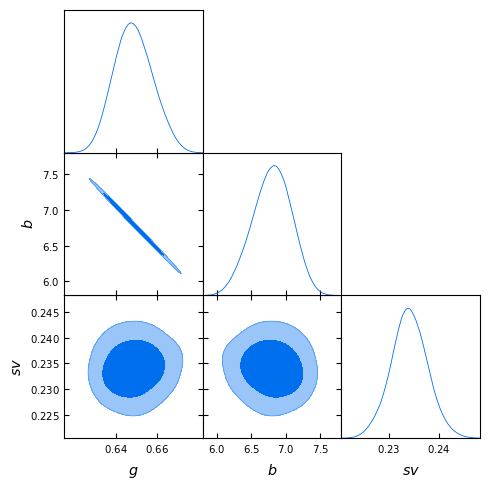

In [6]:
Parameters = "gbsv"

info = {"likelihood": {"agostini": my_like}}

guess = [0.665, 6.301, 0.230]
g, b, sv = guess
parameters = ["g", "b", "sv"]
info["params"] = odict(
    [
        ["g", {"prior": {"min": 0.0, "max": 0.8}, "ref": g, "proposal": 0.001}],
        ["b", {"prior": {"min": 4.0, "max": 25.0}, "ref": b, "proposal": 0.001}],
        ["sv", {"prior": {"min": 0.0, "max": 2.0}, "ref": sv, "proposal": 0.001}],
    ]
)


info["sampler"] = {
    "mcmc": {
        "burn_in": 300,
        "max_samples": 10000000,
        "Rminus1_stop": 0.05,
        "Rminus1_cl_stop": 0.1,
        "learn_proposal": True,
    }
}

updated_info, products = run(info)
gdsamples = MCSamplesFromCobaya(updated_info, products.products()["sample"], ignore_rows=0.3)

gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples, parameters, filled=True)

mean = gdsamples.getMeans()[: len(parameters)]
sigma = np.sqrt(np.array(gdsamples.getVars()[: len(parameters)]))
covmat = gdsamples.getCovMat().matrix[: len(parameters), : len(parameters)]
plt.savefig(
    f"{directory}{Calibration}/{Evolution}/{Evolution}_{Equation}_{Calibration}_{Data}_{Parameters}.pdf",
    format="pdf",
    bbox_inches="tight",
)
print(mean)
print(sigma)

In [7]:
datafinal = np.vstack((mean, sigma))
myheader = "Mean and 1 sigma of values"
np.savetxt(
    f"{directory}{Calibration}/{Evolution}/{Evolution}_{Equation}_{Calibration}_{Data}_{Parameters}.txt",
    datafinal,
    fmt="%16.12e",
    header=myheader,
    delimiter=",",
)

# Extracting saved mean and sigma of calibration of QSO

In [8]:
directory = "/media/ash/1tb/github/Quasar-Cosmology/Ashley/"
Calibration = "calib"
Evolution = "noEvol"
Equation = "lum"
Data = "quasar"
Parameters = "gbsv"
data_previous = np.loadtxt(
    f"{directory}{Calibration}/{Evolution}/{Evolution}_{Equation}_{Calibration}_quasar_gbsv.txt",
    delimiter=",",
)
mean0 = data_previous[0, :]
sigma0 = data_previous[1, :]
print(mean0)
print(sigma0)

[0.64849056 6.80129462 0.23405725]
[0.00926884 0.2807846  0.00365025]


In [9]:
def my_like(H0):
    conversionfrom_cm_to_Mpc = 3.08567758 * 10**24  # 1 Mpc = 10^6 * 3.0857 * 10^16 * 10^2 cm
    ckm = 299792.458
    gerr = sigma0[0]
    berr = sigma0[1]
      
    O_m  = 0.3
    
    O_l = 1 - O_m
    coefQ = (ckm / H0) * (1 + zQ)  # Units of this is Mpc
    d_par = np.array([])

    for i in zQ:
        Integ = quad(integrand, 0, i, args=(O_m, O_l))
        d_par = np.append(d_par, Integ[0])

    d_mpc = np.array(coefQ * d_par)  # Distance luminosity # Unit of it is Mpc
    d_cm = d_mpc * conversionfrom_cm_to_Mpc  # As flux unit is [erg s^(-1) cm^(-2)], 1 cm = 1/ (3.0857 *10^24) Mpc


    # unit of Luminosity is erg /s # Flux units erg s^-1 cm^-2, hence d_cm is used
    logLumUV = logFluxUV + np.log10(4 * np.pi * d_cm**2)
    logLumX = logFluxX + np.log10(4 * np.pi * d_cm**2)
    logLumUVerr = logFluxUVerr
    logLumXerr = logFluxXerr
    
    logLumXth = g * logLumUV + b  # unit of Luminosity is erg /s
    sigma2 = np.array(sv**2 + g**2 * logLumUVerr**2 + gerr**2 * logLumUV**2 + berr**2 + logLumXerr**2)
    
    chi2 = np.sum(np.array((logLumXth - logLumX) ** 2 / sigma2))
    loglikeQ = (-1 / 2) * np.sum(np.log(sigma2)) - 1 / 2 * chi2
    
    return loglikeQ

[agostini] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {agostini: 13.9}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: H0:70
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2022-08-25 10:04:18 : 1 steps taken -- still burning in, 300 accepted steps left.
[mcmc] Finished burn-in phase: discarded 300 accepted steps.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 0.826088 after 32 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 1.023

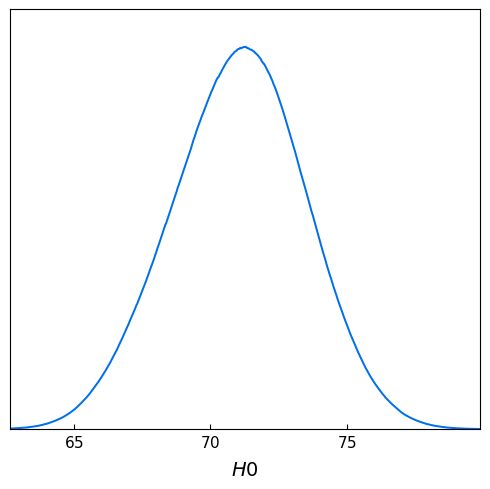

In [10]:
Parameters = "H0"
info = {"likelihood": {"agostini": my_like}}

H0 = 70.0
parameters = ["H0"]
info["params"] = odict(
    [
    ["H0", {"prior": {"min": 50, "max": 100}, "ref": H0, "proposal": 0.001}],
    ]
)




info["sampler"] = {
    "mcmc": {
        "burn_in": 300,
        "max_samples": 10000000,
        "Rminus1_stop": 0.05,
        "Rminus1_cl_stop": 0.1,
        "learn_proposal": True,
    }
}

updated_info, products = run(info)
gdsamples = MCSamplesFromCobaya(updated_info, products.products()["sample"], ignore_rows=0.3)

gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples, parameters, filled=True)

mean = gdsamples.getMeans()[: len(parameters)]
sigma = np.sqrt(np.array(gdsamples.getVars()[: len(parameters)]))
covmat = gdsamples.getCovMat().matrix[: len(parameters), : len(parameters)]
plt.savefig(
    f"{directory}{Calibration}/{Evolution}/{Evolution}_{Equation}_{Calibration}_{Data}_{Parameters}.pdf",
    format="pdf",
    bbox_inches="tight",
)
print(mean)
print(sigma)

# Gaussian Priors (H0)

[agostini] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {agostini: 16.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: H0:70
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2022-08-25 10:06:14 : 1 steps taken -- still burning in, 300 accepted steps left.
[mcmc] Finished burn-in phase: discarded 300 accepted steps.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 1.857468 after 32 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 7.974

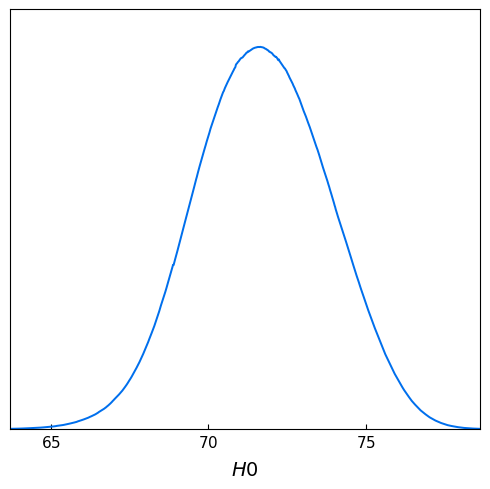

In [11]:
Parameters = "H0"
info = {"likelihood": {"agostini": my_like}}

H0 = 70.0
parameters = ["H0"]
info["params"] = odict(
    [
    ["H0", {"prior": {"dist": "norm", "loc": 73.040, "scale": 3*1.040}, "ref": H0,"proposal":0.01}],
    ]
)


info["sampler"] = {
    "mcmc": {
        "burn_in": 300,
        "max_samples": 10000000,
        "Rminus1_stop": 0.05,
        "Rminus1_cl_stop": 0.1,
        "learn_proposal": True,
    }
}

updated_info, products = run(info)
gdsamples = MCSamplesFromCobaya(updated_info, products.products()["sample"], ignore_rows=0.3)

gdplot = gdplt.getSubplotPlotter(width_inch=5)
gdplot.triangle_plot(gdsamples, parameters, filled=True)

mean = gdsamples.getMeans()[: len(parameters)]
sigma = np.sqrt(np.array(gdsamples.getVars()[: len(parameters)]))
covmat = gdsamples.getCovMat().matrix[: len(parameters), : len(parameters)]
plt.savefig(
    f"{directory}{Calibration}/{Evolution}/Gaussian_{Evolution}_{Equation}_{Calibration}_{Data}_{Parameters}.pdf",
    format="pdf",
    bbox_inches="tight",
)
print(mean)
print(sigma)